In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import natsort

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("tf version =",tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

tf version = 2.1.0


## Import data

In [2]:
tpath = "ESOL/ESOL.csv"

data0 = pd.read_csv(tpath)
data0["Compound ID"].replace({"Atovaquone(0,430mg/ml) - neutral": "Atovaquone"}, inplace=True)
data0["Compound ID"].replace({"Etoposide (148-167,25mg/ml)": "Etoposide"}, inplace=True)
data0["Compound ID"].replace({"Sparsomycin (3,8mg/ml)": "Sparsomycin"}, inplace=True)
data0["Compound ID"].replace({"Digoxin (L1=41,8mg/mL, L2=68,2mg/mL, Z=40,1mg/mL)": "Digoxin"}, inplace=True)

data0.head()

data = data0.iloc[np.random.permutation(len(data0))] #randomly shuffles rows

data.head()

Compound ID  ESOL predicted log solubility in mols per litre  \
444           1-Nonene                                            -3.427   
123       m-Nitrophenol                                           -2.318   
301  1,1-Dichloroethane                                           -1.576   
203              Phoxim                                           -4.557   
862   2,3,3',4,4',5-PCB                                           -7.425   

     Minimum Degree  Molecular Weight  Number of H-Bond Donors  \
444               1           126.243                        0   
123               1           139.110                        1   
301               1            98.960                        0   
203               1           298.304                        0   
862               1           360.882                        0   

     Number of Rings  Number of Rotatable Bonds  Polar Surface Area  \
444                0                          6                0.00   
123                1                          1               63.37   
301                0                          0                0.00   
203                1                          7               63.84   
862                2                          1                0.00   

     measured log solubility in mols per litre  \
444                                     -5.050   
123                                     -1.010   
301                                     -1.290   
203                                     -4.862   
862                                     -7.820   

                                    smiles  
444                             CCCCCCCC=C  
123                     Oc1cccc(c1)N(=O)=O  
301                               CC(Cl)Cl  
203         CCOP(=S)(OCC)ON=C(C#N)c1ccccc1  
862  Clc1ccc(cc1Cl)c2cc(Cl)c(Cl)c(Cl)c2Cl

## Convert Smiles to Images
- Smile is converted into image(80x80 px) and saved as [iname].png in [path]
- while loop loops over all smiles in table

In [31]:
n = 0
n_max = data.shape[0]

while n < n_max:
    
    smi = data.iloc[n,9]

    size = (56,56)
    ipath = "ESOL_img/" + str(n) + ".png"

    mol = Chem.MolFromSmiles(smi)

    Draw.MolToImageFile(mol,ipath,size = size)
    
    n += 1


## Preprocess generated images

In [32]:
filename = natsort.natsorted(glob.glob("ESOL_img/*.png"))

img_list = [cv2.imread(file) for file in filename]


gimg_list = []
for img in img_list:
    gimg_list.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))    #list is converted to gray img's
    

for f in filename:      # delets images after converting them to array
    os.remove(f)

### Generate three arrays
- gimg_array = features
- Name = Compound ID
- comp_sol = log(sol) of compound

In [33]:
comp_sol = np.array(data["measured log solubility in mols per litre"].tolist())
gimg_array = (np.array(gimg_list)/255)
name = np.array(data["Compound ID"].tolist())


## Test if labels are linked in correct way

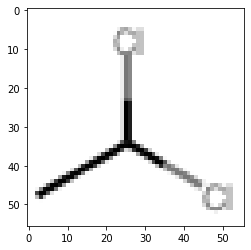

1,1-Dichloroethane
-1.29


In [34]:
t = 2

plt.imshow(gimg_array[t], cmap = "gray")
plt.show()

print(name[t])
print(comp_sol[t])

## Generate training_data and test_data:

In [35]:
X_full = gimg_array.reshape(-1, size[0], size[1],1)
y_full = comp_sol

s = 0.9  #size in percent of training data from full data

train_size =round(len(X_full)*s)


X_train = X_full[:train_size]
X_test = X_full[train_size:]
y_train = y_full[:train_size]
y_test = y_full[train_size:]


print("X_train:",len(X_train),X_train.shape)
print("X_test:",len(X_test),X_test.shape)
print("y_train:",len(y_train))
print("y_test:",len(y_test))



X_train: 1015 (1015, 56, 56, 1)
X_test: 113 (113, 56, 56, 1)
y_train: 1015
y_test: 113


## Creating  Dense NN Tensorflow Model

In [15]:
def build_model():
  model = keras.Sequential([
    layers.Conv2D(8, (6, 6), activation='relu', input_shape=(X_train.shape[1:])),
    layers.MaxPooling2D((3, 3)),
    layers.Flatten(),
    layers.Dense(1)
  ])


  optimizer = tf.keras.optimizers.Adam(0.0001)


  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


model = build_model()

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 51, 51, 8)         296       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 17, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2312)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2313      
Total params: 2,609
Trainable params: 2,609
Non-trainable params: 0
_________________________________________________________________
None


## Training of the NN

In [ ]:
EPOCHS = 100

history = model.fit(
  X_train, y_train,
  epochs = EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])

## Review Results of NN training

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 2])
plt.ylabel('MAE [mol/l]')

## Using Test data to see how the NN performs

In [ ]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: +/- {:5.2f} mol/l".format(mae))

In [ ]:
test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [mol/l]')
plt.ylabel('Predictions [mol/l]')
lims = [-6, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [mol/l]")
_ = plt.ylabel("Count")

## Fine tuning all in one

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 54, 54, 64)        640       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 25, 25, 32)        18464     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                294976    
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)              

113/113 - 0s - loss: 2.7293 - mae: 1.2978 - mse: 2.7207
Testing set Mean Abs Error: +/-  1.30 mol/l


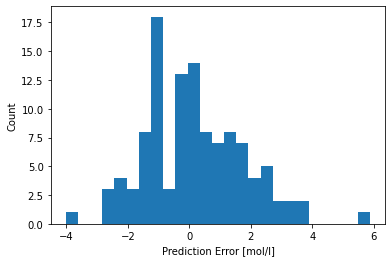

In [36]:
def build_model():
  model = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    layers.MaxPooling2D((2, 2)),
      
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
      
    
    layers.Flatten(),
    layers.Dense(64, kernel_regularizer = keras.regularizers.l2(0.0001), activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(8, kernel_regularizer = keras.regularizers.l2(0.0001), activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
  ])


  optimizer = tf.keras.optimizers.Adam(0.0001)


  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


model = build_model()

print(model.summary())

EPOCHS = 40

history = model.fit(
  X_train, y_train, batch_size = 32,
  epochs = EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([1, 2])
plt.ylabel('log(sol)')
plt.show()

loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: +/- {:5.2f} mol/l".format(mae))

test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [mol/l]')
plt.ylabel('Predictions [mol/l]')
lims = [-7, 4]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [mol/l]")
_ = plt.ylabel("Count")

plt.show()

   ## Benchmarkmodel
    
    
- layers.Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
- layers.MaxPooling2D((2, 2)),
      
- layers.Conv2D(32, (3, 3), activation='relu'),
- layers.MaxPooling2D((2, 2)),
      
    
- layers.Flatten(),
- layers.Dense(64, kernel_regularizer = keras.regularizers.l2(0.0001), activation='relu'),
- layers.Dropout(0.3),
- layers.Dense(8, kernel_regularizer = keras.regularizers.l2(0.0001), activation='relu'),
- layers.Dropout(0.2),
- layers.Dense(1)